 # Precision of R11G11B10F.
 The following graphs demonstrate the precision of R11G11B10F texture in a great blog post ["Small float formats – R11G11B10F precision"](https://bartwronski.com/2017/04/02/small-float-formats-r11g11b10f-precision/) by Bartłomiej Wroński. The original graphs are drawn by Mathematica, and here is my implementation by using NumPy and Matplotlib.

In [122]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('default')
plot_style = {'alpha': 0.7}
fig_save_options = {'bbox_inches': 'tight', 'pad_inches': 0.1}

def srgb_to_linear(x):
    # y = x.copy()
    # mask = x < 0.04045
    # y[mask] /= 12.92
    # y[~mask] = np.power((x[~mask] + 0.055) / 1.055, 2.4)
    # return y
    return np.where(x < 0.04045, x / 12.92, ((x + 0.055) / 1.055) ** 2.4)

def linear_to_srgb(x):
    return np.where(x < 0.0031308, 12.92 * x, 1.055 * np.power(x, 1/2.4) - 0.055)

def as_linear8(x):
    return np.around(x * 255) / 255

def as_srgb8(x):
    # 8-bit linear quantization of sRGB encoded value first, then convert back to linear domain.
    return srgb_to_linear(as_linear8(linear_to_srgb(x)))

def as_float_x(x, exponent_bit_count, mantissa_bit_count):
    """
    Modify mantissa and exponent number to convert float with given bit count.
    """
    m, e = np.frexp(x)
    m *= 2
    e -= 1

    max_exponent = 1 << (exponent_bit_count - 1)
    min_exponent = -(max_exponent - 1) - mantissa_bit_count # Includes subnormal range

    overflow_mask = e >= max_exponent
    e[overflow_mask] = -1
    m[overflow_mask] = float('inf')
    
    subnormal_mask = e < min_exponent
    m[subnormal_mask] = 0.0
    e[subnormal_mask] = 0.0    # Less than the subnormals.
    
    round_scale = 1 << mantissa_bit_count
    m[~subnormal_mask] = np.around(m[~subnormal_mask] * round_scale) / round_scale   # Truncate mantissa
    
    return m * (2.0 ** e)

def as_float16(x):
    return as_float_x(x, 5, 10)

def as_float10(x):
    return as_float_x(x, 5, 5)

def as_float11(x):
    return as_float_x(x, 5, 6)



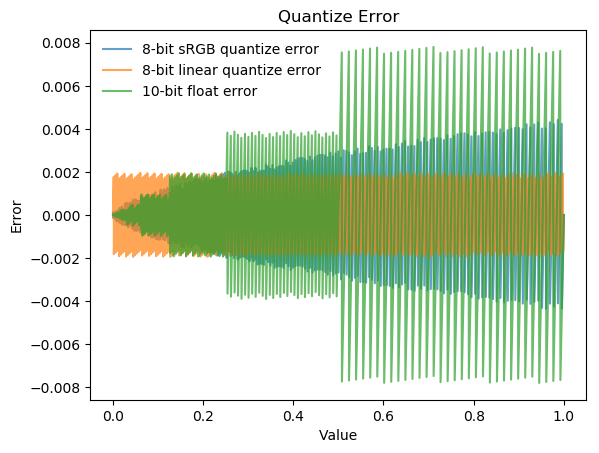

In [123]:
x = np.linspace(0.0001, 1.0, 3000)
y8 = x - as_linear8(x)
y8srgb = x - as_srgb8(x)
y10f = x - as_float10(x)
plt.title('Quantize Error')
plt.xlabel('Value')
plt.ylabel('Error')
plt.plot(x, y8srgb, label='8-bit sRGB quantize error', **plot_style)
plt.plot(x, y8, label='8-bit linear quantize error', **plot_style)
plt.plot(x, y10f, label='10-bit float error', **plot_style)
plt.legend(loc='upper left', frameon=False)
plt.show()


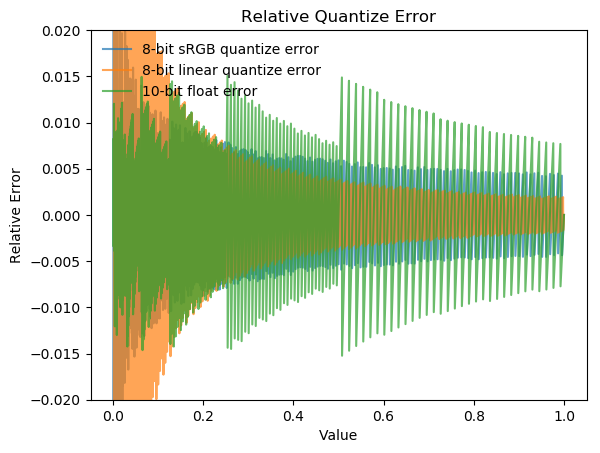

In [124]:
# Display with relative error.
plt.ylim(-0.02, 0.02)
plt.title('Relative Quantize Error')
plt.xlabel('Value')
plt.ylabel('Relative Error')
plt.plot(x, y8srgb / x, label='8-bit sRGB quantize error', **plot_style)
plt.plot(x, y8 / x, label='8-bit linear quantize error', **plot_style)
plt.plot(x, y10f / x, label='10-bit float error', **plot_style)
plt.legend(loc='upper left', frameon=False)
plt.show()



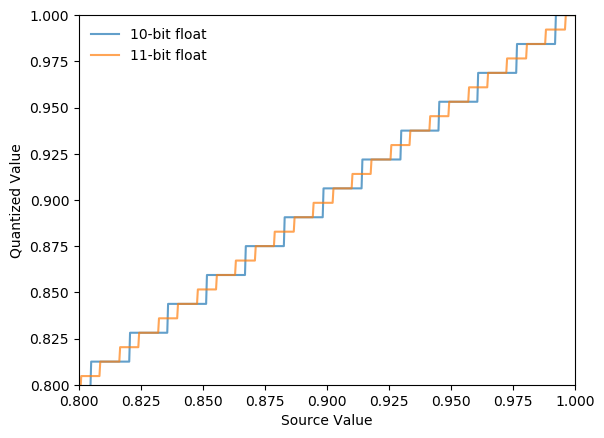

In [125]:
plt.xlim(0.8, 1.0)
plt.ylim(0.8, 1.0)
plt.xlabel('Source Value')
plt.ylabel('Quantized Value')
plt.plot(x, as_float10(x), label='10-bit float', **plot_style)
plt.plot(x, as_float11(x), label='11-bit float', **plot_style)
plt.legend(loc='upper left', frameon=False)
plt.show()



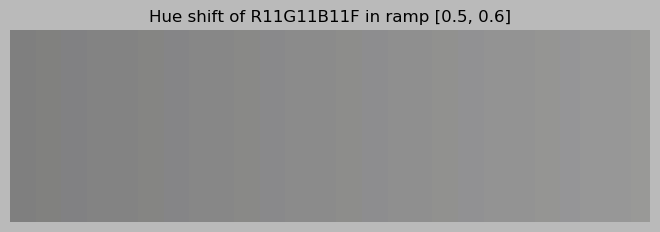

In [126]:
x = np.linspace(0.5, 0.6, 100)
c = np.repeat(x, 5)
f10 = as_float10(c)
f11 = as_float11(c)
color_ramp = np.vstack((f11, f11, f10)).transpose()
img = np.ones((150, 1, 1)) * color_ramp

fig = plt.figure()
fig.patch.set_facecolor((0.73, 0.73, 0.73))
plt.title('Hue shift of R11G11B11F in ramp [0.5, 0.6]')
plt.xticks([])
plt.yticks([])
plt.subplots_adjust(0.0, 0.0, 1.0, 0.94, wspace=0, hspace=0)
plt.axis('off')
plt.imshow(img)



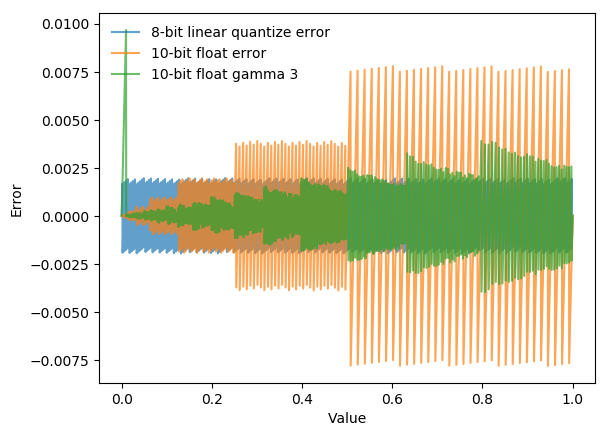

In [127]:
# Apply power 3 to put more bits on highlight instead of shadow.
# This could be seen as the opposite of gamma 1/2.2.
x = np.linspace(0.0, 1.0, 3000)
y8 = x - as_linear8(x)
y10f = x - as_float10(x)
y10f3 = x - as_float10(x ** 3.0) ** (1.0 / 3.0)
plt.xlabel('Value')
plt.ylabel('Error')
plt.plot(x, y8, label='8-bit linear quantize error', **plot_style)
plt.plot(x, y10f, label='10-bit float error', **plot_style)
plt.plot(x, y10f3, label='10-bit float gamma 3', **plot_style)
plt.legend(loc='upper left', frameon=False)
plt.show()


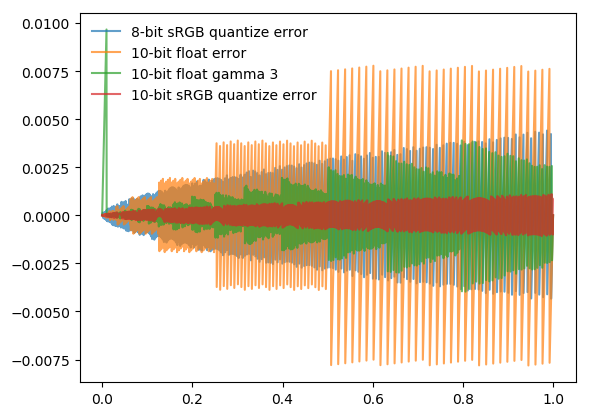

In [128]:
def as_linear10(x):
    return np.around(x * 1024) / 1024

def as_srgb10(x):
    # 8-bit linear quantization of sRGB encoded value first, then convert back to linear domain.
    return srgb_to_linear(as_linear10(linear_to_srgb(x)))

y8srgb = x - as_srgb8(x)
y10srgb = x - as_srgb10(x)
y10f = x - as_float10(x)
y10f3 = x - as_float10(x ** 3.0) ** (1.0 / 3.0)
plt.plot(x, y8srgb, label='8-bit sRGB quantize error', **plot_style)
plt.plot(x, y10f, label='10-bit float error', **plot_style)
plt.plot(x, y10f3, label='10-bit float gamma 3', **plot_style)
plt.plot(x, y10srgb, label='10-bit sRGB quantize error', **plot_style)
plt.legend(loc='upper left', frameon=False)
plt.show()


 There is a spike in 10-bit float gamma 3 when x <= 0.00966989.

 ```x[y10f3 / x > 0.99]```

 array([0.00033344, 0.00066689, 0.00100033, 0.00133378, 0.00166722,
        0.00200067, 0.00233411, 0.00266756, 0.003001  , 0.00333444,
        0.00366789, 0.00400133, 0.00433478, 0.00466822, 0.00500167,
        0.00533511, 0.00566856, 0.006002  , 0.00633545, 0.00666889,
        0.00700233, 0.00733578, 0.00766922, 0.00800267, 0.00833611,
        0.00866956, 0.009003  , 0.00933645, 0.00966989])

 Their cubed can't represented by subnormals of 10-bit float whose minimum is 0.0000019073486328125.

 array([3.70740988e-11, 2.96592790e-10, 1.00100067e-09, 2.37274232e-09,
        4.63426235e-09, 8.00800534e-09, 1.27164159e-08, 1.89819386e-08,
        2.70270180e-08, 3.70740988e-08, 4.93456255e-08, 6.40640427e-08,
        8.14517950e-08, 1.01731327e-07, 1.25125083e-07, 1.51855509e-07,
        1.82145047e-07, 2.16216144e-07, 2.54291244e-07, 2.96592790e-07,
        3.43343229e-07, 3.94765004e-07, 4.51080560e-07, 5.12512342e-07,
        5.79282793e-07, 6.51614360e-07, 7.29729486e-07, 8.13850616e-07,
        9.04200195e-07])

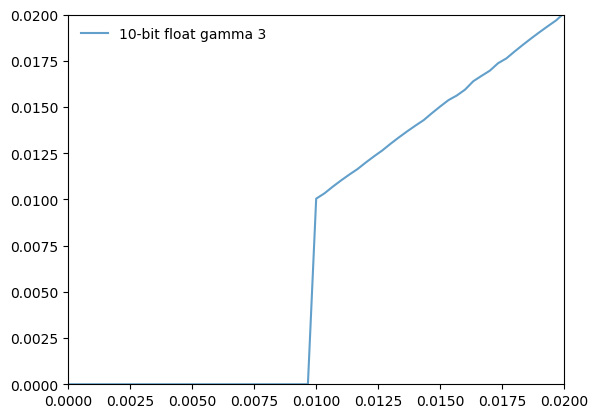

In [129]:
plt.xlim(0, 0.02)
plt.ylim(0, 0.02)
plt.plot(x, as_float10(x ** 3.0) ** (1.0 / 3.0), label='10-bit float gamma 3', **plot_style)
plt.legend(loc='upper left', frameon=False)
plt.show()


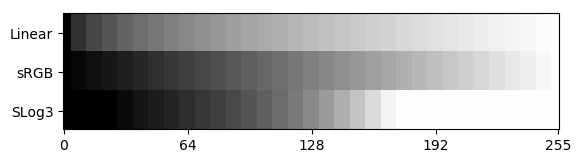

In [130]:
def ramp_to_image(x, height=20):
    scalar_img = (np.ones((height, 1)) * x)
    return np.clip(scalar_img[..., np.newaxis], 0.0, 1.0) * np.ones(3)

def linear_map(x, segment_num):
    return np.around(x * segment_num) / segment_num

def cineon_log_to_linear(x):
    return (np.power(10, (1023 * x -685) / 300) - 0.0108) / (1.0 - 0.0108)

def sony_slog3_to_linear(x):
    # https://github.com/ampas/aces-dev/blob/master/transforms/ctl/idt/vendorSupplied/sony/IDT.Sony.SLog3_SGamut3.ctl
    return np.where(x >= 171.2102946929 / 1023.0, 
        np.power(10.0, (x*1023.0-420.0)/261.5)*(0.18+0.01)-0.01,
        (x*1023.0-95.0)*0.01125000/(171.2102946929-95.0))

x = np.linspace(0.0, 1.0, 256)
l = linear_map(x, 32)

img_linear = ramp_to_image(l)
img_srgb = ramp_to_image(srgb_to_linear(l)) # Evenly distribute levels on sRGB curve.
img_log =ramp_to_image(cineon_log_to_linear(l))

I = np.vstack((img_linear, img_srgb, img_log))

# Add annotation
fig, ax = plt.subplots()
x_ticks = [0, 64, 128, 192, 255]
ax.set_xticks(x_ticks)
ax.set_yticklabels(x_ticks)
ax.set_yticks(np.arange(3) * 20 + 10)
ax.set_yticklabels(['Linear', 'sRGB', 'SLog3'])
plt.imshow(linear_to_srgb(I))
plt.show()


 # Building a Tonemapper
 [Timothy Lottes](https://gpuopen.com/author/tlottes/) has shared wonderful slides about the design of tone mapper curve in the presentation ["Advanced Techniques and Optimization of VDR Color Pipelines"](https://32ipi028l5q82yhj72224m8j-wpengine.netdna-ssl.com/wp-content/uploads/2016/03/GdcVdrLottes.pdf) p.39. Here is step-by-step progress:

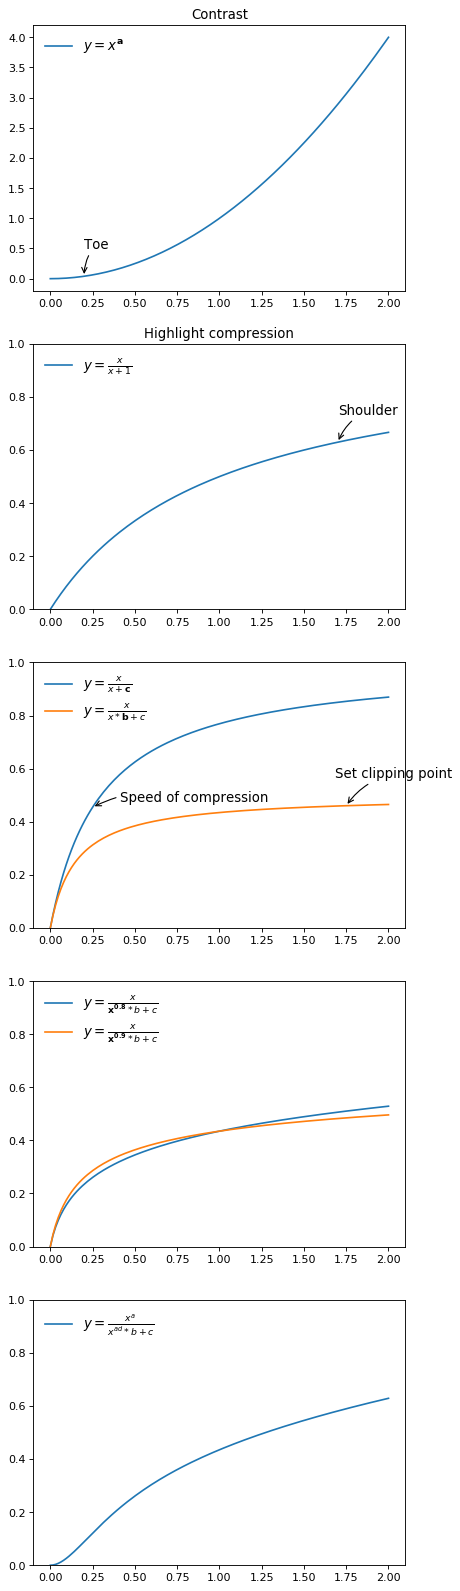

In [131]:
plt.figure(figsize=(6, 25), dpi=80)
x = np.linspace(0, 2, 128)

t = 0.2
f = lambda x : np.power(x, 2)
plt.subplot(5, 1, 1)
plt.title('Contrast')
plt.plot(x, f(x), label=r'$y=x^{\mathbf{a}}$')
plt.annotate('Toe', xy=(t, f(t)),
             xytext=(0, +25), textcoords='offset points', fontsize=12,
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"))
plt.legend(loc='upper left', frameon=False, prop={'size': 12})

plt.subplot(5, 1, 2)
t = 1.7
f = lambda x : x / (x + 1)
plt.ylim(0.0, 1.0)
plt.title('Highlight compression')
plt.plot(x, f(x), label=r'$y=\frac{x}{x + 1}$')
plt.annotate('Shoulder', xy=(t, f(t)),
             xytext=(0, +25), textcoords='offset points', fontsize=12,
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"))
plt.legend(loc='upper left', frameon=False, prop={'size': 12})

plt.subplot(5, 1, 3)
plt.ylim(0.0, 1.0)
t = 0.25
f = lambda x : x / (x + 0.3)
plt.plot(x, f(x), label=r'$y=\frac{x}{x + \mathbf{c}}$')
plt.annotate('Speed of compression', xy=(t, f(t)),
             xytext=(25, 5), textcoords='offset points', fontsize=12,
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"))

t = 1.75
f = lambda x : x / (x * 2 + 0.3)
plt.plot(x, f(x), label=r'$y=\frac{x}{x * \mathbf{b} + c}$')
plt.annotate('Set clipping point', xy=(t, f(t)),
             xytext=(-10, +25), textcoords='offset points', fontsize=12,
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"))
plt.legend(loc='upper left', frameon=False, prop={'size': 12})


plt.subplot(5, 1, 4)
plt.ylim(0.0, 1.0)
f = lambda x, d: x / (np.power(x, d) * 2 + 0.3)
plt.plot(x, f(x, 0.8), label=r'$y=\frac{x}{ \mathbf{x^{0.8}} * b + c}$')
plt.plot(x, f(x, 0.9), label=r'$y=\frac{x}{ \mathbf{x^{0.9}} * b + c}$')
plt.legend(loc='upper left', frameon=False, prop={'size': 12})

def tone_curve(x, a, b, c, d):
    z = np.power(x, a)
    return z / (np.power(z, d) * b + c)

plt.subplot(5, 1, 5)
plt.ylim(0.0, 1.0)
tc = tone_curve(x, 2, 2, 0.3, 0.8)
plt.plot(x, tc, label=r'$y=\frac{x^a}{x^{ad} * b + c}$')
plt.legend(loc='upper left', frameon=False, prop={'size': 12})


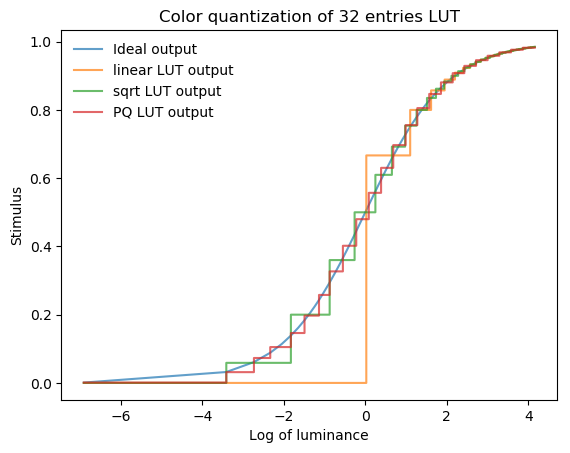

In [132]:
def Reinhard_tonemap(x):
    return x / (x + 1.0)

def slice_32(x):
    # Input should be in [0, 1]
    return np.around(x * 32) / 32

def linear_to_PQ(x, max_pq_value=1000.0):
    # https://en.wikipedia.org/wiki/High-dynamic-range_video#Perceptual_Quantizer
    m1 = 0.1593017578125
    m2 = 78.84375
    c1 = 0.8359375
    c2 = 18.8515625
    c3 = 18.6875
    p = np.power(x / max_pq_value, m1)
    return np.power((c1 + c2 * p) / (1.0 + c3 * p), m2)

def PQ_to_linear(x, max_pq_value=1000.0):
    m1 = 0.1593017578125
    m2 = 78.84375
    c1 = 0.8359375
    c2 = 18.8515625
    c3 = 18.6875
    p = np.power(x, 1.0 / m2)
    return np.power(np.maximum(p - c1, 0.0) / (c2 - c3 * p), 1.0 / m1) * max_pq_value

x = np.linspace(0.001, 64, 2000)
xs = np.log(x)
y = (Reinhard_tonemap(x))

y_linear = Reinhard_tonemap(slice_32(x / 64) * 64)
y_sqrt = Reinhard_tonemap(slice_32(np.sqrt(x / 64)) ** 2 * 64)
y_sqrt = Reinhard_tonemap(slice_32(np.sqrt(x / 64)) ** 2 * 64)
y_pq = Reinhard_tonemap(PQ_to_linear(slice_32(linear_to_PQ(x, 100.0)), 100))

plt.title('Color quantization of 32 entries LUT')
plt.xlabel('Log of luminance')
plt.ylabel('Stimulus')
plt.plot(xs, y, label='Ideal output', **plot_style)
plt.plot(xs, y_linear, drawstyle='steps-post', label='linear LUT output', **plot_style)
plt.plot(xs, y_sqrt, drawstyle='steps-post', label='sqrt LUT output', **plot_style)
plt.plot(xs, y_pq, drawstyle='steps-post', label='PQ LUT output', **plot_style)
plt.legend(loc='upper left', frameon=False)
# plt.savefig('lut_quantization.png', **fig_save_options)
plt.show()


In [133]:
lut_res = 64
s = np.linspace(0, 1, lut_res)
data = np.stack(np.meshgrid(s, s, s), axis=-1)
linear_data = srgb_to_linear(data)

def plot_color_lut(lut, title):
    # lut is a 2D image array
    n = 4
    plt.figure(figsize=(5, 5), dpi=80)
    plt.suptitle(title)
    blue_tile_stride = (lut.shape[0] - 1) / (n ** 2 - 1)
    for i in range(n * n):
        ax = plt.subplot(n, n, i + 1)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        plt.axis('off')
        img = linear_to_srgb(lut[:, :, int(i * blue_tile_stride)])
        plt.imshow(np.clip(img, 0.0, 1.0), aspect='auto')
    plt.subplots_adjust(0.0, 0.0, 1.0, 0.94, wspace=0, hspace=0)
    plt.show()


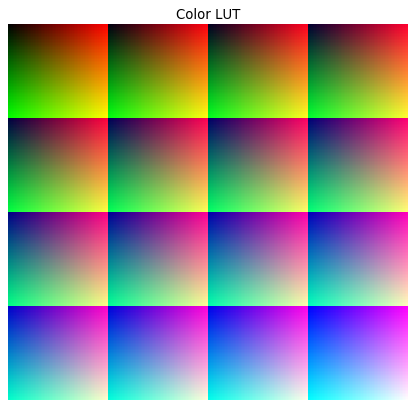

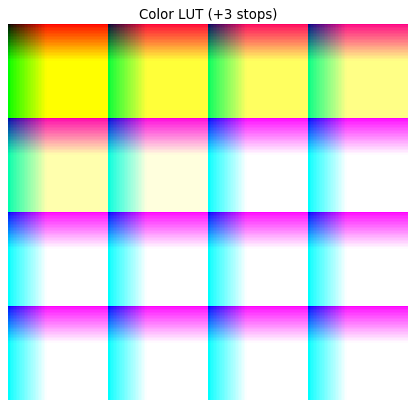

In [134]:
plot_color_lut(linear_data, 'Color LUT')

plot_color_lut(linear_data * 8, 'Color LUT (+3 stops)')


 Apply tone curve to RGB channels separately would get desaturation around the overexposure region as below:

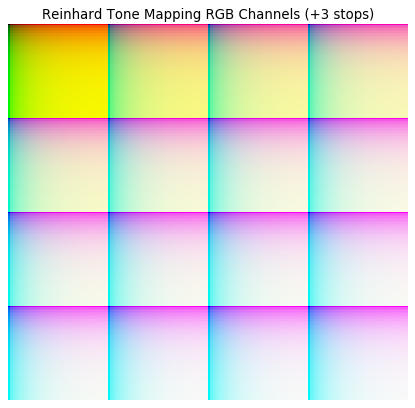

In [135]:
img = linear_to_srgb(Reinhard_tonemap(linear_data * 8))
plot_color_lut(img, 'Reinhard Tone Mapping RGB Channels (+3 stops)')


 While applying tone curve to the **max** of RGB channels could resolve the desaturation problem. But the color of first tile at upper left corner has incorrect hue. When the exposure increases, it should tend toward white instead of yellow. If we apply tone curve to RGB channels directly, the color would never go towards white if the B channel is zero. Therefore, there are some

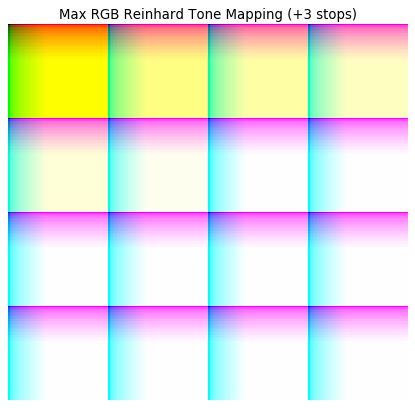

In [136]:
def maxrgb_tonemap(img, tonemap_func):
    max_color_comp = np.amax(img, axis=-1)[:, :, :, np.newaxis]
    max_color_comp = tonemap_func(max_color_comp)
    ratio = img / np.maximum(max_color_comp, 1e-5)
    return np.clip(ratio * max_color_comp, 0.0, 1.0)

img = linear_to_srgb(maxrgb_tonemap(linear_data * 8, Reinhard_tonemap))
plot_color_lut(img, 'Max RGB Reinhard Tone Mapping (+3 stops)')



 To make color transition more like a real film, Timothy Lottes has proposed [a formula](https://32ipi028l5q82yhj72224m8j-wpengine.netdna-ssl.com/wp-content/uploads/2016/03/GdcVdrLottes.pdf) to add non-linear channel crosstalk.

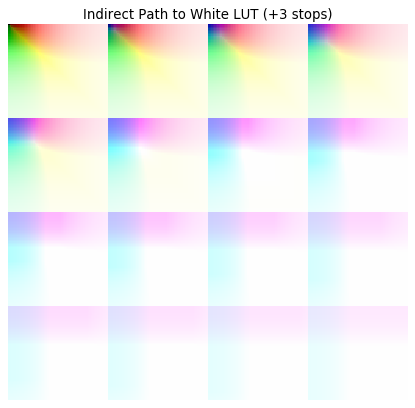

In [137]:
def indirect_path_to_white(img, crosstalk, saturation, cross_saturation, tonemap):
    max_color_comp = np.amax(img, axis=-1)[:, :, :, np.newaxis]
    max_color_comp = tonemap(max_color_comp)
    ratio = img / np.maximum(max_color_comp, 1e-5)

    ratio = np.power(ratio, saturation / cross_saturation)
    coeffs = np.power(max_color_comp, crosstalk)
    ratio = ratio * (1.0 - coeffs) + np.ones(3) * coeffs
    ratio = np.power(ratio, cross_saturation)
    return np.clip(ratio * max_color_comp, 0.0, 1.0)

img_idp = linear_to_srgb(indirect_path_to_white(linear_data * 8, 1.0, 3.0, 3.0, Reinhard_tonemap))
plot_color_lut(img_idp, 'Indirect Path to White LUT (+3 stops)')



 # ACES Tone Mapper
 [ACES (Academy Color Encoding System)](https://www.oscars.org/science-technology/sci-tech-projects/aces) defines an image interchange framework. Traditional tone mapping could be seen as RRT (reference rendering transform) + ODT (output device transform) in ACES. All source code of color transformation could be found on their [github](https://github.com/ampas/aces-dev/tree/v1.0.3/transforms/ctl) page. They also provided reference images for each color transformation. [UE4](https://www.desmos.com/calculator/h8rbdpawxj) and [Unity](https://github.com/colour-science/colour-unity/blob/master/Assets/Colour/Notebooks/CIECAM02_Unity.ipynb) both had their numerical fitting about RRT + ODT. Here we ported all relevant functions and used Unity's curve fitting to show the results of ACES tone mapping.

In [138]:
# Helper functions for ACES tone mapping.
def rgb_2_saturation(img):
    mi = np.amin(img, axis=-1)
    ma = np.amax(img, axis=-1)
    return (np.maximum(ma, 1e-4) - np.maximum(mi, 1e-4)) / np.maximum(ma, 1e-2)

def rgb_2_yc(img):
    r = img[..., 0]
    g = img[..., 1]
    b = img[..., 2]

    ycRadiusWeight = 1.75
    chroma = np.sqrt(b * (b - g) + g * (g - r) + r * (r - b))
    return (b + g + r + ycRadiusWeight * chroma) / 3.0

def rgb_2_hue(img):
    r = img[..., 0]
    g = img[..., 1]
    b = img[..., 2]

    hue = np.where(np.logical_and(r == g, g == b), 0.0, (180.0 / np.pi) * np.arctan2(np.sqrt(3.0) * (g - b), 2.0 * r - g - b))
    hue[hue < 0.0] += 360.0
    return hue

def center_hue(hue, centerH):
    hueCentered = hue - centerH
    hueCentered[hueCentered < -180.0] += 360.0
    hueCentered[hueCentered > 180.0] -= 360.0
    return hueCentered

def sigmoid_shaper(x):
    # Sigmoid function in the range 0 to 1 spanning -2 to +2.
    t = np.maximum(1.0 - np.abs(x / 2.0), 0.0)
    y = 1.0 + np.sign(x) * (1.0 - t * t)
    return y / 2.0

def glow_fwd(ycIn, glowGainIn, glowMid):
    glowGainOut = np.empty_like(ycIn)
    
    mask1 = ycIn <= 2.0 / 3.0 * glowMid
    mask2 = ycIn >= 2.0 * glowMid
    glowGainOut[mask1] = glowGainIn[mask1]
    glowGainOut[mask2] = 0.0

    mask3 = np.logical_not(np.logical_or(mask1, mask2))
    glowGainOut[mask3] = glowGainIn[mask3] * (glowMid / ycIn[mask3] - 0.5)
    return glowGainOut

def smoothstep(a, b, x):
    t = np.clip((x - a) / (b - a), 0.0, 1.0)
    return t * t * (3.0 - 2.0 * t)

sRGB_2_AP0 = np.array([
    [0.4397010, 0.3829780, 0.1773350],
    [0.0897923, 0.8134230, 0.0967616],
    [0.0175440, 0.1115440, 0.8707040]]).transpose()

AP1_2_sRGB = np.array([
    [1.70505, -0.62179, -0.08326],
    [-0.13026, 1.14080, -0.01055],
    [-0.02400, -0.12897, 1.15297]]).transpose()

AP0_2_AP1_MAT = np.array([
    [1.4514393161, -0.2365107469, -0.2149285693],
    [-0.0765537734,  1.1762296998, -0.0996759264],
    [0.0083161484, -0.0060324498,  0.9977163014]]).transpose()

AP1_2_XYZ_MAT = np.array([
    [0.6624541811, 0.1340042065, 0.1561876870],
    [0.2722287168, 0.6740817658, 0.0536895174],
    [-0.0055746495, 0.0040607335, 1.0103391003]]).transpose()

AP1_RGB2Y = np.array([0.272229, 0.674082, 0.0536895])

D60_2_D65_CAT = np.array([
    [0.98722400, -0.00611327, 0.0159533],
    [-0.00759836,  1.00186000, 0.0053302],
    [0.00307257, -0.00509595, 1.0816800]]).transpose()

XYZ_2_AP1_MAT = np.array([
    [1.6410233797, -0.3248032942, -0.2364246952],
    [-0.6636628587,  1.6153315917,  0.0167563477],
    [0.0117218943, -0.0082844420,  0.9883948585]]).transpose()

XYZ_2_REC709_MAT = np.array([
    [3.2409699419, -1.5373831776, -0.4986107603],
    [-0.9692436363,  1.8759675015,  0.0415550574],
    [0.0556300797, -0.2039769589,  1.0569715142]]).transpose()

def ACES_to_ACEScg(img):
    return img.dot(AP0_2_AP1_MAT)

def RRT_tone_curve(x):
    a = 278.5085
    b = 10.7772
    c = 293.6045
    d = 88.7122
    e = 80.6889
    return (x * (a * x + b)) / (x * (c * x + d) + e)

def XYZ_2_xyY(XYZ):
    divisor = np.maximum(XYZ.dot(np.ones(3)), 1e-4)
    return np.stack((
            XYZ[..., 0] / divisor,
            XYZ[..., 1] / divisor,
            XYZ[..., 1]), axis=-1)

def xyY_2_XYZ(xyY):
    m = xyY[..., 2] / np.maximum(xyY[..., 1], 1e-4)
    XYZ = np.stack((xyY[..., 0], xyY[..., 2], 1.0 - xyY[..., 0] - xyY[..., 1]), axis=-1)
    XYZ[..., 0] *= m
    XYZ[..., 2] *= m
    return XYZ

def darkSurround_to_dimSurround(linearCV):
    DIM_SURROUND_GAMMA = 0.9811

    XYZ = linearCV.dot(AP1_2_XYZ_MAT)

    xyY = XYZ_2_xyY(XYZ)
    xyY[..., 2] = np.clip(xyY[..., 2], 0.0, np.finfo(np.float32).max)
    xyY[..., 2] = np.power(xyY[..., 2], DIM_SURROUND_GAMMA)
    XYZ = xyY_2_XYZ(xyY)

    return XYZ.dot(XYZ_2_AP1_MAT)


In [139]:
def aces_tonemap(color_srgb):
    # https://github.com/ampas/aces-dev/blob/v1.0.3/transforms/ctl/rrt/RRT.ctl
    # https://github.com/colour-science/colour-unity/blob/master/Assets/Colour/Notebooks/CIECAM02_Unity.ipynb
    RRT_GLOW_GAIN = 0.05
    RRT_GLOW_MID = 0.08
    RRT_RED_SCALE = 0.82
    RRT_RED_PIVOT = 0.03
    RRT_RED_HUE = 0.0
    RRT_RED_WIDTH = 135.0

    aces = color_srgb.dot(sRGB_2_AP0)
    
    saturation = rgb_2_saturation(aces)
    ycIn = rgb_2_yc(aces)
    s = sigmoid_shaper((saturation - 0.4) / 0.2)
    addedGlow = 1.0 + glow_fwd(ycIn, RRT_GLOW_GAIN * s, RRT_GLOW_MID)
    aces *= addedGlow[..., np.newaxis]

    hue = rgb_2_hue(aces)
    centeredHue = center_hue(hue, RRT_RED_HUE)
    
    hueWeight = smoothstep(0.0, 1.0, 1.0 - abs(2.0 * centeredHue / RRT_RED_WIDTH))
    hueWeight *= hueWeight
    
    aces[..., 0] += hueWeight * saturation * (RRT_RED_PIVOT - aces[..., 0]) * (1.0 - RRT_RED_SCALE)
    acescg = np.maximum(0.0, aces.dot(AP0_2_AP1_MAT))   # ACES to RGB rendering space
    
    # Global desaturation
    luminance = acescg.dot(AP1_RGB2Y)
    RRT_SAT_FACTOR = 0.96
    acescg[..., 0] = luminance * (1.0 - RRT_SAT_FACTOR) + acescg[..., 0] * RRT_SAT_FACTOR
    acescg[..., 1] = luminance * (1.0 - RRT_SAT_FACTOR) + acescg[..., 1] * RRT_SAT_FACTOR
    acescg[..., 2] = luminance * (1.0 - RRT_SAT_FACTOR) + acescg[..., 2] * RRT_SAT_FACTOR

    rgbPost = RRT_tone_curve(acescg)

    # Apply gamma adjustment to compensate for dim surround
    linearCV = darkSurround_to_dimSurround(rgbPost)

    # Apply desaturation to compensate for luminance difference
    luminance = linearCV.dot(AP1_RGB2Y)
    ODT_SAT_FACTOR = 0.93
    linearCV[..., 0] = luminance * (1.0 - ODT_SAT_FACTOR) + linearCV[..., 0] * ODT_SAT_FACTOR
    linearCV[..., 1] = luminance * (1.0 - ODT_SAT_FACTOR) + linearCV[..., 1] * ODT_SAT_FACTOR
    linearCV[..., 2] = luminance * (1.0 - ODT_SAT_FACTOR) + linearCV[..., 2] * ODT_SAT_FACTOR

    # Convert to display primary encoding
    XYZ = linearCV.dot(AP1_2_XYZ_MAT)

    # Apply CAT from ACES white point to assumed observer adapted white point
    XYZ = XYZ.dot(D60_2_D65_CAT)

    # CIE XYZ to display primaries
    return np.clip(XYZ.dot(XYZ_2_AP1_MAT).dot(AP1_2_sRGB), 0.0, 1.0)


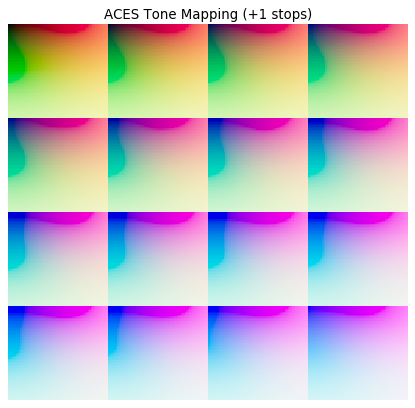

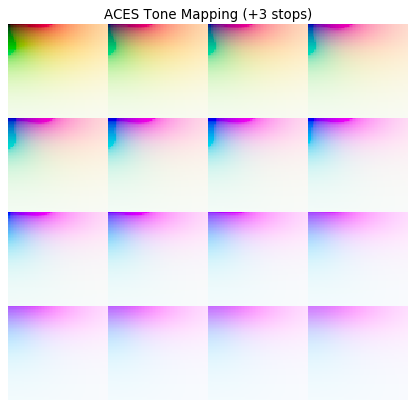

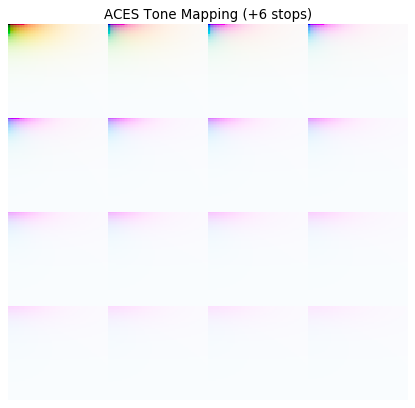

In [140]:
img = linear_to_srgb(aces_tonemap(linear_data * 2))
plot_color_lut(img, 'ACES Tone Mapping (+1 stops)')

img = linear_to_srgb(aces_tonemap(linear_data * 8))
plot_color_lut(img, 'ACES Tone Mapping (+3 stops)')

img = linear_to_srgb(aces_tonemap(linear_data * 64))
plot_color_lut(img, 'ACES Tone Mapping (+6 stops)')